## Installs and Imports

In [89]:
%%capture
!pip install tqdm pyLDAvis gensim numpy bokeh contractions
!conda install -c conda-forge huggingface_hub -y

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import warnings
import contractions
import demoji
import string
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# NLP stuff
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('wordnet')
import spacy

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from sklearn.manifold import TSNE
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Acquisition via Gmail API

In [92]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'Medium Daily Digest')

In [93]:
print(len(messages))

606


In [94]:
print(messages[0])

{'id': '17b824280fe22188', 'threadId': '17b824280fe22188'}


In [95]:
# experimenting with a single message
message = messages[0]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
print(msg.keys())

dict_keys(['id', 'threadId', 'labelIds', 'snippet', 'payload', 'sizeEstimate', 'historyId', 'internalDate'])


In [96]:
print(msg['snippet'])

Sejal Dua Stories for Sejal Dua @sejaldua·Member From your following Edit who you follow Towards Data Science Dario Radečić in Towards Data Science· 6 min read Tired of JupyterLab? Try DataSpell — A


In [97]:
print(msg['payload']['parts'][0]['body']['data'][:200])

U3RvcmllcyBmb3IgU2VqYWwgRHVhDQpAc2VqYWxkdWEgKGh0dHBzOi8vbWVkaXVtLmNvbS9Ac2VqYWxkdWE_c291cmNlPWVtYWlsLWUzNTNkZGIwYzEyNS0xNjI5OTYxODE4ODc1LWRpZ2VzdC5yZWFkZXItLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tZDk1ZjQ4M2Ff


In [98]:
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
print(msg_body[:1500])

Stories for Sejal Dua
@sejaldua (https://medium.com/@sejaldua?source=email-e353ddb0c125-1629961818875-digest.reader-------------------------d95f483a_cd11_4249_8d81_e8decd7f7c92)
·Member (https://medium.com/@sejaldua?source=email-e353ddb0c125-1629961818875-digest.reader-------------------------d95f483a_cd11_4249_8d81_e8decd7f7c92)

From your following
Edit who you follow (https://medium.com/me/following/people?source=email-e353ddb0c125-1629961818875-digest.reader-------------------------d95f483a_cd11_4249_8d81_e8decd7f7c92-31)

Dario Radečić (https://medium.com/@radecicdario?source=email-e353ddb0c125-1629961818875-digest.reader-7f60cf5620c9-fb7cbc1280d4----0-1------------------d95f483a_cd11_4249_8d81_e8decd7f7c92-31-ceb7e32b_2d50_4483_a5d7_187b958b3d30)
 in Towards Data Science·6 min read

Tired of JupyterLab? Try DataSpell - A New Amazing IDE for Data Science

If JupyterLab and PyCharm had a baby…

Mansi Sarda (https://medium.com/@mansisarda1999?source=email-e353ddb0c125-1629961818875-

In [99]:
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)[:5]

[('How to Create Large Music Datasets Using Spotipy',
  'The Fastest and Cleanest Way to Get Music Related Data for Machine Learning',
  'Max Hilsdorf',
  'Towards Data Science ',
  '9'),
 ('The machine learning behind delivering relevant ads',
  'Felix Fang | Software Engineer, Advertiser Solutions Group',
  'Pinterest Engineering',
  'Pinterest Engineering Blog ',
  '9'),
 ('Building a semantic search engine with dual space word embeddings',
  'Imagine you have a large set of news articles, and want to provide a way to allow your users to search…',
  'Chris Zhu',
  'Mage ',
  '7'),
 ('How to Quickly Preprocess and Visualize Text Data with TextHero',
  'How to quickly preprocess, represent and visualize the text data in Python using TextHero library',
  'Chetan Ambi',
  'Towards AI ',
  '4'),
 ('Evolving the Partner Program',
  'Grow your community, earn more money.',
  'Medium Staff',
  '3 min read ',
  '7')]

### Regex Parsing of HTML Text

In [101]:
def parse_email_digest(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    
    # workaround for old email Medium Daily Digest format prior to March 23, 2021
    if len(articles) == 0:
        articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n(.*) \r\n\ in (.*)\r\n(.*) min read', text, re.MULTILINE)]
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body and decode it from UTF-8
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    fetched_articles = parse_email_digest(date, msg_body)
    num_articles_fetched.append(len(fetched_articles))
    for articles in fetched_articles:
        data.append([date, *articles])


100%|██████████| 606/606 [01:45<00:00,  5.73it/s]


In [102]:
for entry in data[:3]:
    print(entry)

[Timestamp('2021-08-26 11:40:00+0000', tz='UTC'), 'How to Create Large Music Datasets Using Spotipy', 'The Fastest and Cleanest Way to Get Music Related Data for Machine Learning', 'Max Hilsdorf', 'Towards Data Science ', '9']
[Timestamp('2021-08-26 11:40:00+0000', tz='UTC'), 'The machine learning behind delivering relevant ads', 'Felix Fang | Software Engineer, Advertiser Solutions Group', 'Pinterest Engineering', 'Pinterest Engineering Blog ', '9']
[Timestamp('2021-08-26 11:40:00+0000', tz='UTC'), 'Building a semantic search engine with dual space word embeddings', 'Imagine you have a large set of news articles, and want to provide a way to allow your users to search…', 'Chris Zhu', 'Mage ', '7']


In [103]:
# TROUBLESHOOT HERE
# identify all zero articles fetched digest emails
message = messages[num_articles_fetched.index(0)]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
for date_dict in msg['payload']['headers']:
    if date_dict['name'] == 'Date':
        date = date_dict['value']
date = pd.to_datetime(date)
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
# print(text)

In [104]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df.to_csv('article_data_via_gmail_api.csv', index=False)
df

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-26 11:40:00+00:00,How to Create Large Music Datasets Using Spotipy,The Fastest and Cleanest Way to Get Music Related Data for Machine Learning,Max Hilsdorf,Towards Data Science,9
1,2021-08-26 11:40:00+00:00,The machine learning behind delivering relevant ads,"Felix Fang | Software Engineer, Advertiser Solutions Group",Pinterest Engineering,Pinterest Engineering Blog,9
2,2021-08-26 11:40:00+00:00,Building a semantic search engine with dual space word embeddings,"Imagine you have a large set of news articles, and want to provide a way to allow your users to search…",Chris Zhu,Mage,7
3,2021-08-26 11:40:00+00:00,How to Quickly Preprocess and Visualize Text Data with TextHero,"How to quickly preprocess, represent and visualize the text data in Python using TextHero library",Chetan Ambi,Towards AI,4
4,2021-08-26 11:40:00+00:00,Evolving the Partner Program,"Grow your community, earn more money.",Medium Staff,3 min read,7
...,...,...,...,...,...,...
9305,2020-01-01 16:30:00+00:00,How to Get the Unquantifiable Benefits of Cold Showers,The surprising side effects that science can't measure and money can't buy,May Pang,Better Humans,10
9306,2020-01-01 16:30:00+00:00,Screw Productivity Hacks: My Morning Routine Is Getting up Late,Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…,Jessica Valenti,GEN,3
9307,2020-01-01 16:30:00+00:00,The Latest Science on Chronic Pain Is Fascinating,"Experts can even predict who's likely to suffer or recover, based on brain structure and personality",Robert Roy Britt,Elemental,14
9308,2020-01-01 16:30:00+00:00,5 scientific myths you probably believe about the Universe,How a little knowledge can bring about some huge misconceptions… and how to fix it.,Ethan Siegel,Starts With A Bang!,8


In [105]:
df = pd.read_csv('article_data_via_gmail_api.csv')
df.head()

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-26 11:40:00+00:00,How to Create Large Music Datasets Using Spotipy,The Fastest and Cleanest Way to Get Music Related Data for Machine Learning,Max Hilsdorf,Towards Data Science,9
1,2021-08-26 11:40:00+00:00,The machine learning behind delivering relevant ads,"Felix Fang | Software Engineer, Advertiser Solutions Group",Pinterest Engineering,Pinterest Engineering Blog,9
2,2021-08-26 11:40:00+00:00,Building a semantic search engine with dual space word embeddings,"Imagine you have a large set of news articles, and want to provide a way to allow your users to search…",Chris Zhu,Mage,7
3,2021-08-26 11:40:00+00:00,How to Quickly Preprocess and Visualize Text Data with TextHero,"How to quickly preprocess, represent and visualize the text data in Python using TextHero library",Chetan Ambi,Towards AI,4
4,2021-08-26 11:40:00+00:00,Evolving the Partner Program,"Grow your community, earn more money.",Medium Staff,3 min read,7


## Quick Exploratory Visualizations

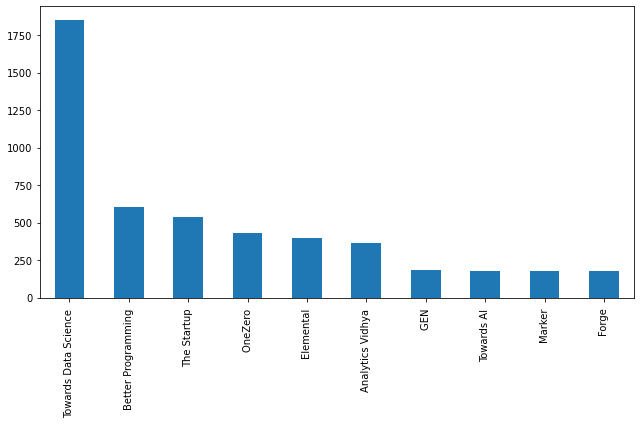

In [106]:
fig = plt.figure(figsize=(9,6))
df['Publication'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/publication_counts.png')

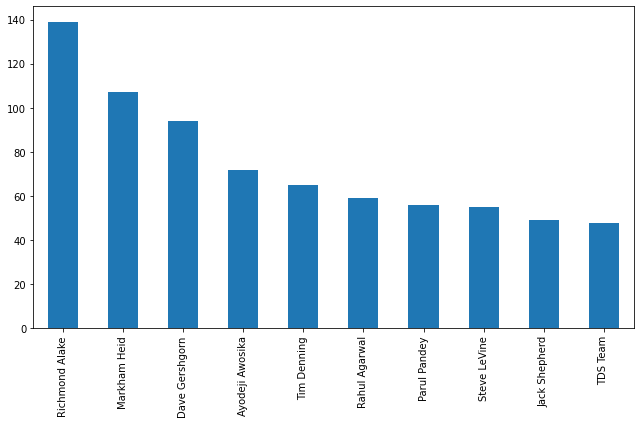

In [107]:
fig = plt.figure(figsize=(9,6))
df['Author'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/author_counts.png')

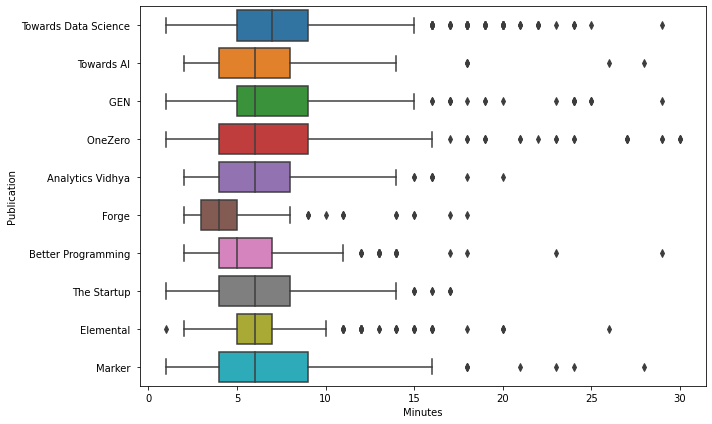

In [108]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=df[(df['Minutes'] <= 30) & (df['Publication'].isin(df['Publication'].value_counts().iloc[:10].index))], x='Minutes', y='Publication')
plt.tight_layout()
fig.savefig('./figures/minutes_publication_boxplot.png')

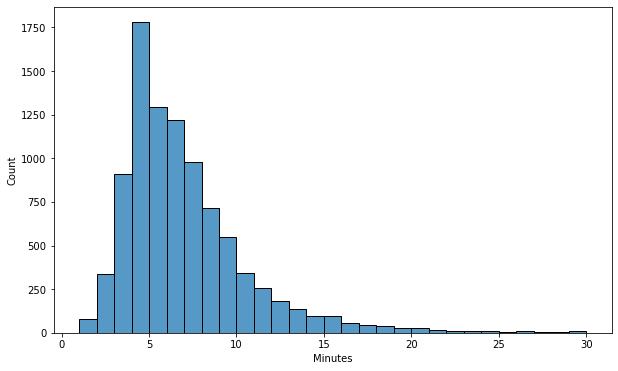

In [109]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.histplot(data=df[(df['Minutes'] <= 30)], x='Minutes', binwidth=1)
fig.savefig('./figures/minutes_distribution.png')

## Cleaning & Preprocessing

In [110]:
def preprocess(text_col):
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # fix contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('not')
    stopwords.remove('no')
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if len(w.strip()) >= 3]))

    return text_col

df['text'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df['text'] = preprocess(df['text'])
print(*df['text'].head(20).values, sep='\n')

create large music datasets using spotipy fastest cleanest way get music related data machine learning
machine learning behind delivering relevant felix fang software engineer advertiser solution group
building semantic search engine dual space word embeddings imagine large set news article want provide way allow user search
quickly preprocess visualize text data texthero quickly preprocess represent visualize text data python using texthero library
evolving partner program grow community earn money
simple way export medium reading list markdown file line python code
visualize time series data using panda guide understanding gain insight timeseries data plotting visualization using panda
puzzle make litre water using litre bucket litre bucket solve problem
automatic smart exploratory data visualization lux python easy eda one line code
exploratory data analysis eda python matplotlib analyzing datasets summarize main characteristic often visual method
five mistake avoid scraping website

## Wordcloud

In [111]:
all_words = ' '.join(df['text'].values).split()
all_words[:20]

['create',
 'large',
 'music',
 'datasets',
 'using',
 'spotipy',
 'fastest',
 'cleanest',
 'way',
 'get',
 'music',
 'related',
 'data',
 'machine',
 'learning',
 'machine',
 'learning',
 'behind',
 'delivering',
 'relevant']

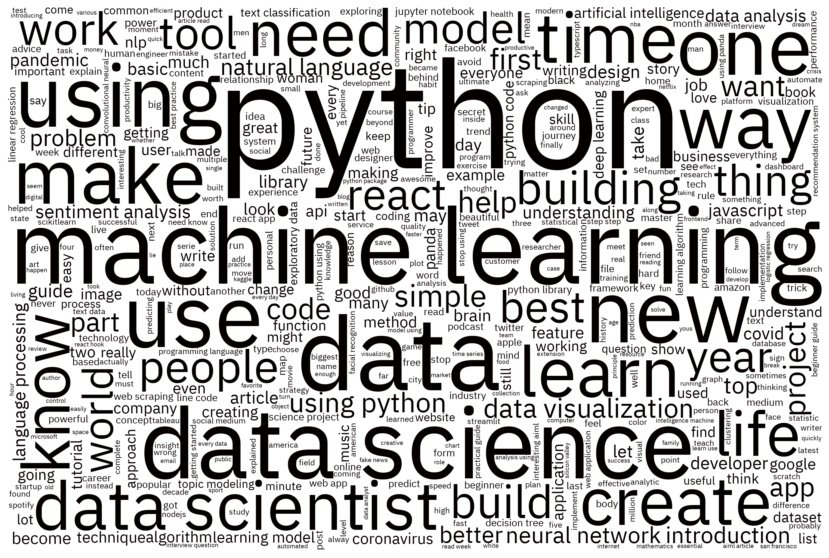

In [112]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500, stopwords=STOPWORDS).generate_from_text(' '.join(df['text'].values))

# set the word color to black
wordcloud.recolor(color_func = black_color_func)
fig = plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig.savefig('./figures/wordcloud.png')

## Topic Modeling Prep

### Data Preprocessing

In [113]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text'].tolist()))
print(data_words[:1])
print("Total docs:", len(data_words))

[['create', 'large', 'music', 'datasets', 'using', 'spotipy', 'fastest', 'cleanest', 'way', 'get', 'music', 'related', 'data', 'machine', 'learning']]
Total docs: 9310


In [114]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [115]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [116]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['create', 'large', 'music', 'dataset', 'use', 'spotipy', 'fast', 'clean', 'way', 'get', 'music', 'relate', 'data', 'machine', 'learn']]


In [117]:
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# def preprocess(text):
#     result = []
#     for token in gensim.utils.simple_preprocess(text):
#         if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(lemmatize_stemming(token))
#     return result


In [118]:
# # Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = [preprocess(' '.join(words)) for words in data_words_bigrams]

# print(data_lemmatized[:1])

### Lemmatization

In [119]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# the preprocessed and lemmatized documents themselves
texts = data_lemmatized

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1)]]


In [120]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('clean', 1),
  ('create', 1),
  ('data', 1),
  ('dataset', 1),
  ('fast', 1),
  ('get', 1),
  ('large', 1),
  ('learn', 1),
  ('machine', 1),
  ('music', 2),
  ('relate', 1),
  ('use', 1),
  ('way', 1)]]

## Latent Dirichlet Allocation (LDA)

In [138]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [139]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.086*"machine" + 0.081*"learn" + 0.037*"learning" + 0.032*"use" + '
  '0.031*"model" + 0.029*"code" + 0.022*"deep" + 0.017*"brain" + '
  '0.015*"predict" + 0.013*"understand"'),
 (1,
  '0.095*"datum" + 0.063*"use" + 0.040*"visualization" + 0.028*"library" + '
  '0.025*"panda" + 0.025*"analysis" + 0.021*"map" + 0.020*"create" + '
  '0.018*"javascript" + 0.015*"python"'),
 (2,
  '0.053*"use" + 0.051*"text" + 0.043*"nlp" + 0.027*"twitter" + '
  '0.024*"sentiment_analysis" + 0.021*"processing" + 0.020*"natural_language" '
  '+ 0.016*"tweet" + 0.016*"classification" + 0.016*"introduction"'),
 (3,
  '0.025*"make" + 0.023*"work" + 0.023*"good" + 0.021*"life" + 0.013*"great" + '
  '0.011*"even" + 0.011*"way" + 0.011*"code" + 0.010*"need" + 0.010*"write"'),
 (4,
  '0.049*"design" + 0.029*"day" + 0.018*"new" + 0.017*"podcast" + '
  '0.015*"product" + 0.014*"long" + 0.013*"neural_network" + '
  '0.013*"environment" + 0.013*"attention" + 0.013*"human"'),
 (5,
  '0.047*"article" + 0.034*"u

### Model Evaluation Metrics

In [140]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -6.59
Coherence Score:  0.31


### Visualize Keywords

In [141]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.094066 -0.211035  1       1        12.428930
7      0.192793 -0.016064  2       1        11.412604
1     -0.208063 -0.171745  3       1        11.343330
0     -0.051972  0.103097  4       1        11.249841
3      0.233143  0.020690  5       1        11.143089
6      0.197083 -0.052256  6       1        9.400158 
9     -0.015170 -0.026779  7       1        9.001387 
2     -0.155137  0.138723  8       1        8.603896 
5     -0.012154 -0.025841  9       1        8.111007 
4     -0.086457  0.241210  10      1        7.305758 , topic_info=               Term         Freq        Total Category  logprob  loglift
27   datum           1393.000000  1393.000000  Default  30.0000  30.0000
8    machine         695.000000   695.000000   Default  29.0000  29.0000
77   science         658.000000   658.000000   Default  28.0000  28.0000
32   text            315.000000   315.000000   Default  27.0000  27.0000
7    learn           1012.000000  1012.000000  Default  26.0000  26.0000
..     ...                   ...          ...      ...      ...      ...
260  part            56.684739    287.848501   Topic10 -4.4791   0.9916 
248  model           43.380885    334.702034   Topic10 -4.7466   0.5733 
99   classification  41.101841    226.663196   Topic10 -4.8006   0.9091 
382  much            39.370766    142.875482   Topic10 -4.8436   1.3276 
125  system          38.931420    96.393978    Topic10 -4.8548   1.7099 

[628 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
957   5      0.957062  able         
876   2      0.923820  accessibility
498   2      0.957219  accord       
609   8      0.968602  act          
752   7      0.795937  add          
...  ..           ...  ...          
97    7      0.029086  year         
97    8      0.019391  year         
97    9      0.161590  year         
97    10     0.006464  year         
1001  7      0.941439  zoom         

[1447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 2, 1, 4, 7, 10, 3, 6, 5])

### LDA Mallet Model

In [125]:
mallet_path = '~/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [126]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False)[:3])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score: ', round(coherence_ldamallet, 2))

[(0,
  [('code', 0.09403789327307492),
   ('text', 0.05736137667304015),
   ('nlp', 0.04658439075265079),
   ('classification', 0.04206500956022945),
   ('processing', 0.024335129497653398),
   ('natural_language', 0.023292195376325396),
   ('line', 0.02242308360855206),
   ('technique', 0.021380149487224057),
   ('word', 0.021380149487224057),
   ('long', 0.020163393012341387)]),
 (1,
  [('make', 0.08641114982578398),
   ('work', 0.06724738675958188),
   ('design', 0.045993031358885016),
   ('tip', 0.02613240418118467),
   ('job', 0.024738675958188152),
   ('love', 0.0210801393728223),
   ('product', 0.020557491289198607),
   ('show', 0.020557491289198607),
   ('trick', 0.019337979094076654),
   ('black', 0.018292682926829267)]),
 (2,
  [('guide', 0.06990934449093444),
   ('python', 0.049860529986053),
   ('simple', 0.04637377963737797),
   ('part', 0.045502092050209206),
   ('easy', 0.03556485355648536),
   ('step', 0.033124128312412834),
   ('tutorial', 0.03207810320781032),
   ('ex

In [127]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Find most optimal number of topics

In [128]:
# NOTE: can take a long time to run...
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)

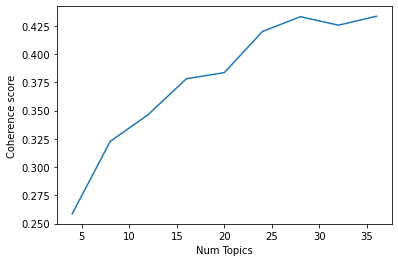

In [129]:
# Graph coherence values vs number of topics
limit=40; start=4; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [130]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.2586
Num Topics = 8  has Coherence Value of 0.3227
Num Topics = 12  has Coherence Value of 0.3465
Num Topics = 16  has Coherence Value of 0.3781
Num Topics = 20  has Coherence Value of 0.3836
Num Topics = 24  has Coherence Value of 0.4199
Num Topics = 28  has Coherence Value of 0.433
Num Topics = 32  has Coherence Value of 0.4255
Num Topics = 36  has Coherence Value of 0.4334


In [131]:
# optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_model = model_list[-3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(15,
  '0.149*"life" + 0.082*"change" + 0.053*"live" + 0.045*"run" + '
  '0.032*"pandemic" + 0.031*"move" + 0.031*"graph" + 0.030*"secret" + '
  '0.030*"set" + 0.027*"release"'),
 (0,
  '0.183*"work" + 0.070*"people" + 0.069*"job" + 0.059*"company" + '
  '0.055*"product" + 0.050*"black" + 0.044*"home" + 0.034*"apple" + '
  '0.022*"facebook" + 0.019*"remote"'),
 (11,
  '0.219*"build" + 0.145*"python" + 0.141*"simple" + 0.048*"system" + '
  '0.037*"add" + 0.036*"scratch" + 0.029*"platform" + 0.029*"minute" + '
  '0.021*"beginner" + 0.021*"provide"'),
 (19,
  '0.122*"tool" + 0.063*"improve" + 0.050*"give" + 0.047*"power" + '
  '0.038*"movie" + 0.038*"show" + 0.033*"test" + 0.033*"watch" + '
  '0.032*"productivity" + 0.030*"performance"'),
 (23,
  '0.132*"nlp" + 0.086*"feature" + 0.068*"processing" + '
  '0.066*"natural_language" + 0.059*"technique" + 0.052*"twitter" + '
  '0.051*"analyze" + 0.043*"sentiment_analysis" + 0.041*"task" + '
  '0.029*"topic"'),
 (10,
  '0.089*"javascript" + 0.

### Finding the dominant topic in each sentence

In [132]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic[['Dominant_Topic']].to_csv('dominant_topic.csv')
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.0693,"app, web, create, application, interactive, deploy, music, map, dashboard, build","[create, large, music, dataset, use, spotipy, fast, clean, way, get, music, relate, data, machine, learn]"
1,1,6.0,0.0701,"learn, machine, learning, deep, unsupervised, supervise, laptop, clustering, support_vector, label","[machine, learn, deliver, relevant, advertiser, solution, group]"
2,2,12.0,0.0879,"model, part, process, predict, search, base, building, customer, series, regression","[build, semantic, search, engine, dual, space, word_embedding, imagine, large, set, news, article, want, provide, way, allow, user, search]"
3,3,17.0,0.0933,"text, classification, word, post, review, tweet, topic_modele, research, scikitlearn, document","[quickly, preprocess, visualize, text, datum, quickly, preprocess, represent, visualize, text, datum, python, use, library]"
4,4,9.0,0.0736,"make, easy, lot, free, content, long, online, hard, table, school","[evolve, partner, program, grow, community, earn, money]"
5,5,8.0,0.0676,"code, write, panda, tip, function, line, trick, method, programmer, clean","[simple, way, export, medium, reading, list, markdown, file, line, code]"
6,6,20.0,0.1058,"datum, analysis, visualization, chart, exploratory, visualize, plotly, statistical, pca, visualizing","[visualize, datum, use, panda, guide, understanding, gain, insight, timeserie, datum, plot, visualization, use, panda]"
7,7,16.0,0.0714,"problem, big, fast, avoid, common, challenge, solve, face, strategy, choose","[puzzle, make, litre, water, use, solve, problem]"
8,8,20.0,0.0840,"datum, analysis, visualization, chart, exploratory, visualize, plotly, statistical, pca, visualizing","[automatic, smart, exploratory, datum, visualization, lux, easy, line, code]"
9,9,20.0,0.0761,"datum, analysis, visualization, chart, exploratory, visualize, plotly, statistical, pca, visualizing","[exploratory, datum, analysis, matplotlib, analyze, dataset, summarize, main, characteristic, often, visual, method]"


### Find the most representative document for each topic

In [133]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(optimal_model.num_topics)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1496,"work, people, job, company, product, black, home, apple, facebook, remote","[white, supremacist, work, culture, zoom, slack, black, woman, get, work, do]"
1,1.0,0.1967,"good, story, medium, talk, tech, practice, great, experience, share, writer","[let, talk, work, tech, feeling, good, year, personal, medium, blog, homebrew, partner, hunter, walk, share, perspective, tech, worker, worry]"
2,2.0,0.1883,"design, important, industry, technology, designer, rule, portfolio, number, follow, visual","[awesome, portfolio, website, amazon, designer, bestfolioscom, collect, good, designer, portfolio, resume, design, resource]"
3,3.0,0.1798,"year, world, end, pandemic, covid, health, study, age, show, public","[stunning, photograph, give, new, appreciation, nature, winner, nature, photographer, year, competition, inspire, delightful]"
4,4.0,0.1542,"project, library, image, dataset, automate, package, cool, report, generate, perform","[full_stack, data, scientist, automate, report, generation, jupyter, automatically, generate, report, useful, wide, range, scenario, regularly, share, datum]"
5,5.0,0.1541,"understand, introduction, explain, basic, user, implement, network, neural_network, type, concept","[introduction, convolutional_neural, network, convolutional_neural, network, neural_network, convolutional, layer]"
6,6.0,0.1515,"learn, machine, learning, deep, unsupervised, supervise, laptop, clustering, support_vector, label","[introduction, svm, support_vector, machine, support_vector, machine, svm, supervise, machine, learn, use]"
7,7.0,0.2104,"react, create, website, api, scrape, hook, custom, form, call, component","[fetch, datum, react, hook, use, effect, hook, api, call, await, suspense, great, way, handle, lifecycle, request, use, react, hook, effect, hook]"
8,8.0,0.1390,"code, write, panda, tip, function, line, trick, method, programmer, clean","[panda, method, help, replace, excel, use, panda, method, transition, excel, save, serious, time]"
9,9.0,0.1323,"make, easy, lot, free, content, long, online, hard, table, school","[easy, way, make, money, learn, code, wait, long, make, money]"


In [134]:
# Number of Documents for Each Topic
topic_df = pd.DataFrame(df_topic_sents_keywords['Dominant_Topic'].value_counts())   
topic_df.reset_index(inplace=True)
topic_df.columns = ['Dominant_Topic', 'Num_Documents']

# Percentage of Documents for Each Topic
topic_df['Perc_Documents'] = topic_df['Num_Documents'].apply(lambda x: round(x/topic_df['Num_Documents'].values.sum(), 4))

# Merge with other df containing keywords for each topic
topic_df = topic_df.merge(sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']], 
                          left_on='Dominant_Topic', right_on='Topic_Num', how='left').drop(columns=['Topic_Num'])

topic_df

,Dominant_Topic,Num_Documents,Perc_Documents,Keywords
0,0.0,600,0.0644,"work, people, job, company, product, black, home, apple, facebook, remote"
1,6.0,510,0.0548,"learn, machine, learning, deep, unsupervised, supervise, laptop, clustering, support_vector, label"
2,3.0,460,0.0494,"year, world, end, pandemic, covid, health, study, age, show, public"
3,1.0,395,0.0424,"good, story, medium, talk, tech, practice, great, experience, share, writer"
4,5.0,383,0.0411,"understand, introduction, explain, basic, user, implement, network, neural_network, type, concept"
5,18.0,382,0.0410,"science, data, datum, scientist, skill, engineer, career, analyst, essential, embrace"
6,8.0,372,0.0400,"code, write, panda, tip, function, line, trick, method, programmer, clean"
7,7.0,360,0.0387,"react, create, website, api, scrape, hook, custom, form, call, component"
8,4.0,360,0.0387,"project, library, image, dataset, automate, package, cool, report, generate, perform"
9,10.0,336,0.0361,"javascript, stop, good, list, idea, podcast, today, powerful, file, difference"


### Visualization

In [142]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8508 samples in 0.005s...
[t-SNE] Computed neighbors for 8508 samples in 0.612s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8508
[t-SNE] Computed conditional probabilities for sample 2000 / 8508
[t-SNE] Computed conditional probabilities for sample 3000 / 8508
[t-SNE] Computed conditional probabilities for sample 4000 / 8508
[t-SNE] Computed conditional probabilities for sample 5000 / 8508
[t-SNE] Computed conditional probabilities for sample 6000 / 8508
[t-SNE] Computed conditional probabilities for sample 7000 / 8508
[t-SNE] Computed conditional probabilities for sample 8000 / 8508
[t-SNE] Computed conditional probabilities for sample 8508 / 8508
[t-SNE] Mean sigma: 0.000028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.309784
[t-SNE] KL divergence after 1000 iterations: 0.776616


In [143]:
# Plot the Topic Clusters using Bokeh

output_notebook()
n_topics = lda_model.num_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

## Export CSV

In [148]:
new_df = df.copy()
new_df.rename(columns={'Date': 'date'}, inplace=True)
new_df['text'] = new_df['text'].astype(str)
new_df[['date', 'text']][:1500].to_csv('medium-suggested-articles.csv', index=False)